# Unsupervised Learning with Hierarchical Clustering  
### What will we learn?
* The intuition behind hierarchical (agglomerative) clustering and the Ward linkage.  
* How to read a dendrogram and decide on an appropriate number of clusters.  
* Practical data‑preprocessing steps (selecting numeric columns, scaling).  
* Dimensionality reduction with PCA for 2‑D exploratory plots.  
* Communicating cluster insights on a world map.

### Part 1: Loading the Country‑Level Indicator Data  
We will use the *“Country‑data.csv”* file from Kaggle  
(<https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data>).  
Each row represents a country and each column an economic or health indicator (e.g., GDP per capita, child mortality).  

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rohan0301/unsupervised-learning-on-country-data")

print("Path to dataset files:", path)

Path to dataset files: /Users/jackthomas/.cache/kagglehub/datasets/rohan0301/unsupervised-learning-on-country-data/versions/2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Assuming your CSV file is named 'Country-data.csv'
# and is located inside the downloaded directory
file_path = os.path.join(path, 'Country-data.csv')

# Now read the CSV file using the file_path
data = pd.read_csv(file_path)
data.head() # Print the first few rows of the DataFrame

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### Part 2: Feature Selection & Quick EDA
* We keep only our features (e.g. everything but country names).

array([[<Axes: title={'center': 'child_mort'}>,
        <Axes: title={'center': 'exports'}>,
        <Axes: title={'center': 'health'}>],
       [<Axes: title={'center': 'imports'}>,
        <Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'inflation'}>],
       [<Axes: title={'center': 'life_expec'}>,
        <Axes: title={'center': 'total_fer'}>,
        <Axes: title={'center': 'gdpp'}>]], dtype=object)

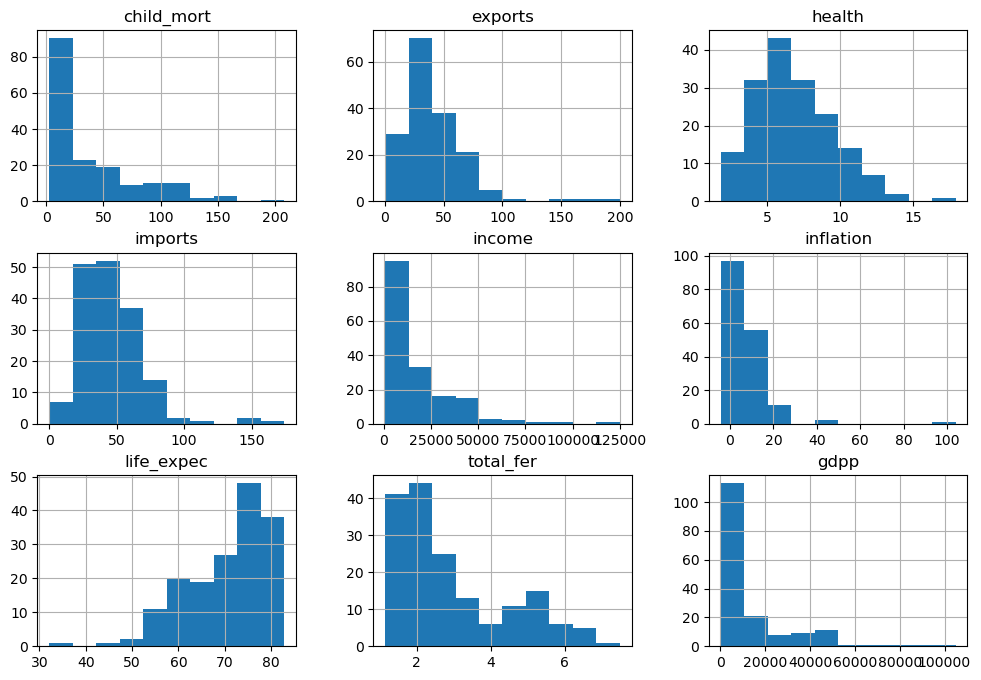

In [4]:
features_df = data.drop(columns= "country")

# Optional sanity‑check visual
features_df.hist(figsize = [12,8])

### Part 3: Standardize by Scaling
- Hierarchical clustering uses Euclidean distance; indicators measured on different scales (GDP vs. fertility) would dominate the metric.  
- We standardise to zero mean / unit variance using `StandardScaler`.  


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)
X_scaled

array([[ 1.29153238, -1.13827979,  0.27908825, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.47965843, -0.09701618, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.09912164, -0.96607302, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541,  1.13030491,  0.0088773 , ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.40647827, -0.59727159, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.15034774, -0.33801514, ..., -2.09278484,
         1.6246091 , -0.62954556]])

### Part 5: Building the Hierarchical Tree
* **Ward linkage** merges clusters that yield the *smallest* increase in total within‑cluster variance.  
* The dendrogram gives us two insights:  
  1. Similarity structure (who merges early).  
  2. Reasonable cut heights (horizontal line) for k clusters.  
We truncate to the last 30 merges to keep the plot readable.  

Text(0, 0.5, 'Distance')

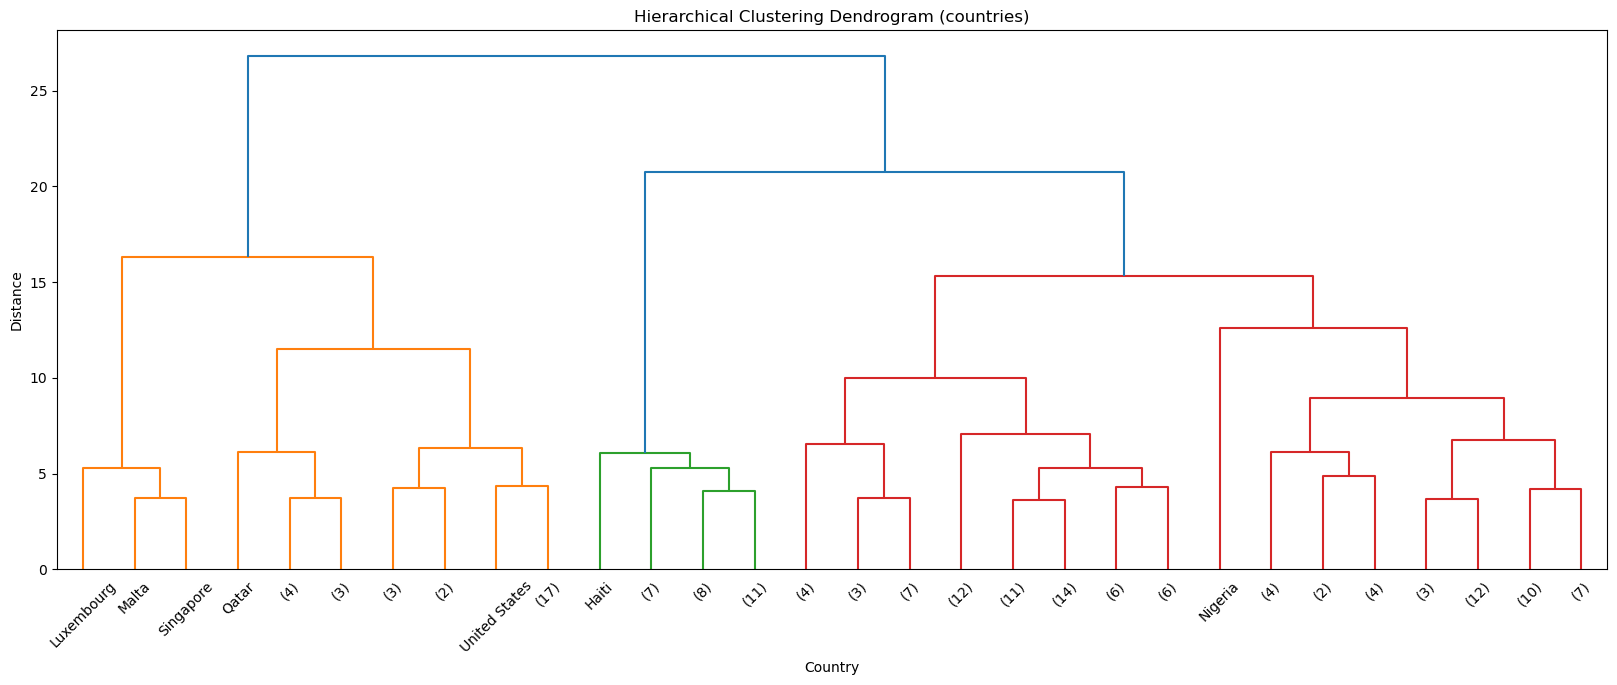

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Standardize the numeric features (centering and scaling)
z = linkage(X_scaled, method = "ward")
country = data["country"].to_list()


plt.figure(figsize = [20,7])
dendrogram(z,
           labels= country,
           truncate_mode="lastp", # truncates the number of examples shown, comment out to see all countries
)
plt.title("Hierarchical Clustering Dendrogram (countries)")
plt.xlabel("Country")
plt.ylabel("Distance")



### Part 6: Choosing k & Assigning Clusters
After visually inspecting the dendrogram we select **k=3** (feel free to experiment).  
Agglomerative clustering with the same linkage method produces integer labels we can append to the dataframe.  


In [45]:
from sklearn.cluster import AgglomerativeClustering

# Select k and assigning cluster label with fit_predict()
k = 5
agg = AgglomerativeClustering(n_clusters=k,
                              linkage="ward")
data["cluster"] = agg.fit_predict(X_scaled)
#data["cluster"].value_counts()#number of countries in each cluster 
#data[data["cluster"] == 3] #see which countries belong to which clusters 

### Part 7: Low‑Dimensional Insight with PCA
**Note:** PCA is *only* for display; it was **not** used to fit the clusters.  

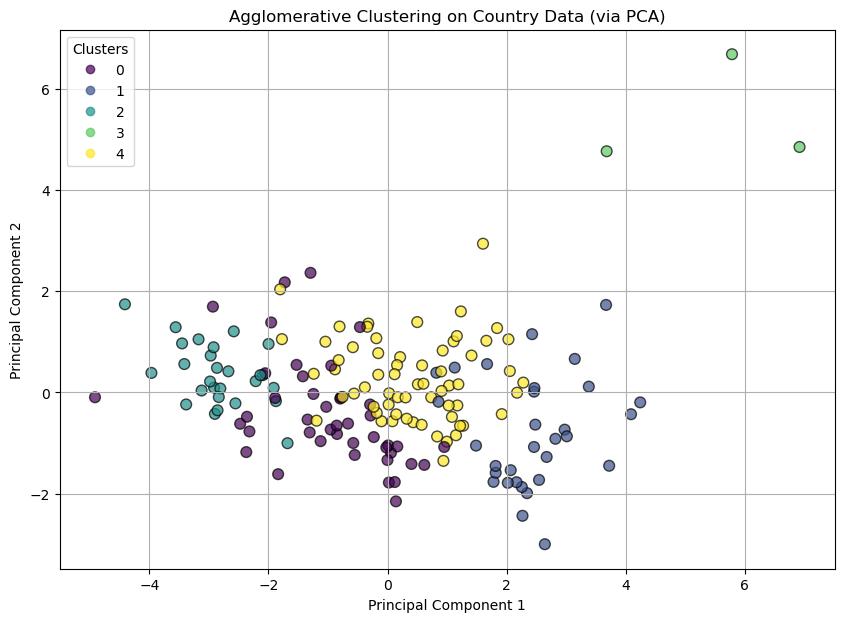

In [46]:
# Step 4: Visualize the Clustering Results Using PCA
from sklearn.decomposition import PCA

cluster_labels = data["cluster"].to_list()
# Reduce the dimensions for visualization (2D scatter plot)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=60, edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Agglomerative Clustering on Country Data (via PCA)')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

### Part 8: Putting Clusters on the Map  
Choropleth maps make the result tangible for non‑technical audiences.  
Plotly Express offers an immediate interactive world map keyed by **country name**.  

In [48]:
import plotly.express as px

# Define a discrete color mapping for the clusters (adjust colors as needed)
color_map = {0:"blue", 1:"orange", 2:"green", 3:"red", 4:"yellow"}  # add more if k>4


# Create the choropleth map
fig = px.choropleth(
    data[['country', 'cluster']],
    locationmode='country names',
    locations='country',
    title='Country Clusters on World Map',
    color='cluster',
    color_discrete_map=color_map
)

# Update the geographic layout and legend settings
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(
    legend_title_text='Cluster',
    legend_title_side='top'
)

fig.show(engine='kaleido')

In [56]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(features_df, cluster_labels)

DecisionTreeClassifier()

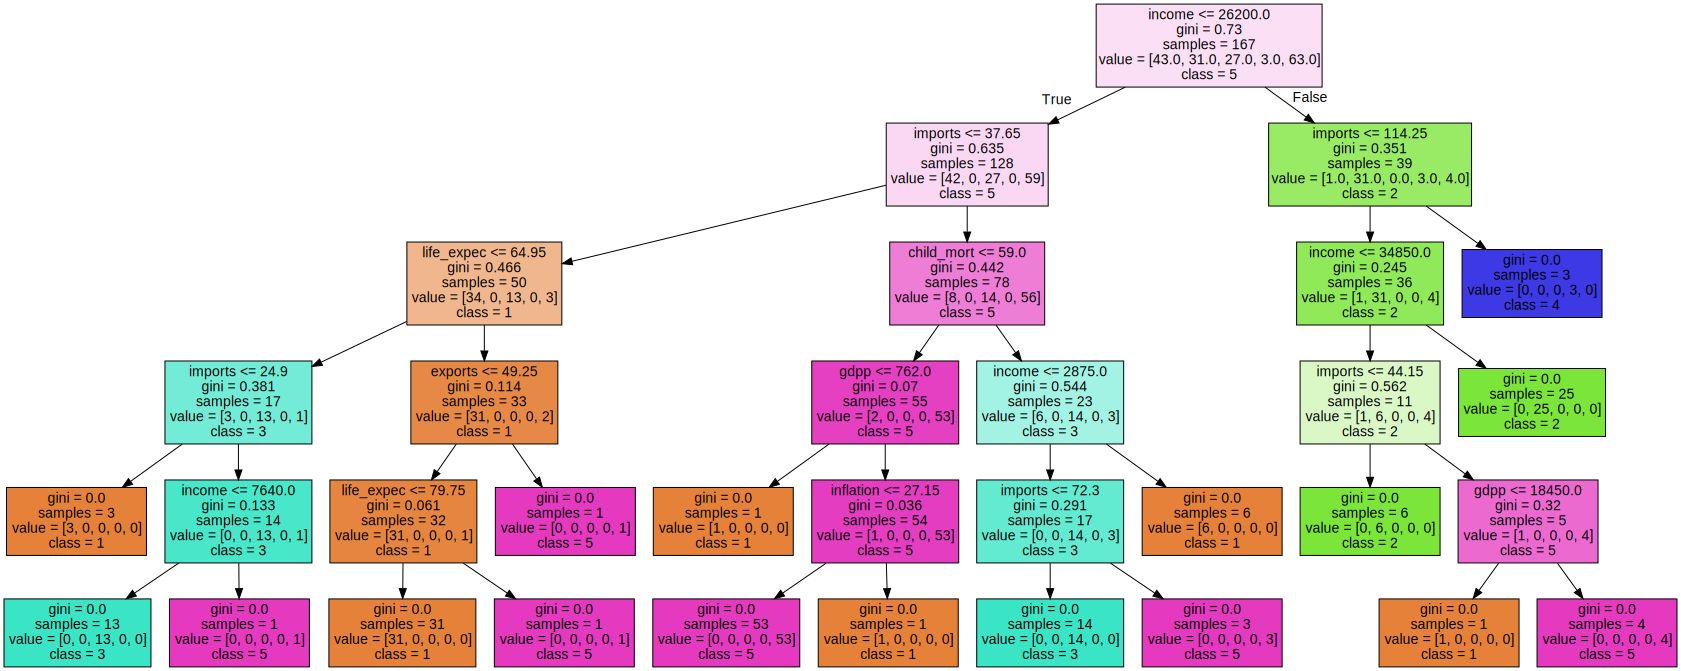

In [57]:
import graphviz
from sklearn import tree

dot_tree = tree.export_graphviz(dt, feature_names = features_df.columns, 
                                class_names = ["1", "2", "3", "4", "5"],
                                filled = True)
graphviz.Source(dot_tree)


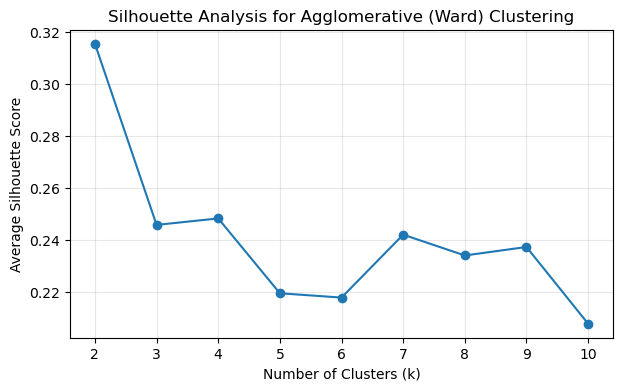

Best k by silhouette: 2  (score=0.315)


In [49]:
# --- OPTIMAL k: Silhouette Elbow ----------------------------------------
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Range of candidate cluster counts
k_range = range(2, 11)     # try 2–10 clusters; adjust as you like
sil_scores = []

for k in k_range:
    # Fit hierarchical clustering with Ward linkage (same as dendrogram)
    labels = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(X_scaled)

    # Silhouette: +1 = dense & well‑separated, 0 = overlapping, −1 = wrong clustering
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

# Plot the curve
plt.figure(figsize=(7,4))
plt.plot(list(k_range), sil_scores, marker="o")
plt.xticks(list(k_range))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Analysis for Agglomerative (Ward) Clustering")
plt.grid(True, alpha=0.3)
plt.show()

# Optional: print best k
best_k = k_range[np.argmax(sil_scores)]
print(f"Best k by silhouette: {best_k}  (score={max(sil_scores):.3f})")